# Imports

In [1]:
import os

import gc

import pandas as pd

from tqdm.notebook import tqdm

import spacy

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Device

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [3]:
device = get_default_device()
device

device(type='cuda')

# Download Dataset

In [4]:
!pip install opendatasets --upgrade --quiet

In [5]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/adityajn105/flickr8k?select=Images'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  shash0704


Your Kaggle Key:

  ································


100%|██████████| 1.04G/1.04G [00:15<00:00, 72.7MB/s]


In [6]:
root_dir = './flickr8k'
print(os.listdir(root_dir))

['captions.txt', 'Images']


In [7]:
root_dir += '/Images'
print(os.listdir(root_dir)[:10])

['2171891283_dedd9cf416.jpg', '2271468944_3264d29208.jpg', '3459858555_c3f0087a72.jpg', '2380765956_6313d8cae3.jpg', '236474697_0c73dd5d8b.jpg', '2750832671_4b39f06acf.jpg', '2090386465_b6ebb7df2c.jpg', '1356543628_c13ebe38fb.jpg', '2228022180_9597b2a458.jpg', '124195430_d14028660f.jpg']


# Prepare Data

In [8]:
image_size = 224
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transform = transforms.Compose([transforms.Resize(image_size),
                          transforms.CenterCrop(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(*stats)])

spacy_eng = spacy.load('en_core_web_sm')

In [9]:
class Vocabulary:
    def __init__(self, freq_threshold = 4):
        self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 3, '<UNK>': 4}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] > self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
                self.stoi[token] if token in self.stoi else self.stoi['<UNK>']
                for token in tokenized_text
        ]

In [10]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform = None, freq_threshold = 4):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        self.img = self.df['image']
        self.captions = self.df['caption']

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.img[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi['<SOS>']]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi['<EOS>'])

        return img, torch.tensor(numericalized_caption)

In [11]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

# Load Data

In [12]:
def get_loader(root_folder, annotation_file, transform, batch_size = batch_size, shuffle = False, num_workers = 4, pin_memory = True):
    dataset = FlickrDataset(root_folder, annotation_file, transform = transform)

    pad_idx = dataset.vocab.stoi['<PAD>']

    loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, collate_fn=MyCollate(pad_idx=pad_idx))

    return loader, dataset

In [13]:
loader, dataset = get_loader(root_dir, './flickr8k/captions.txt', transform)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Visualize Examples

In [14]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [15]:
def show_images(images, nmax=25):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=5).permute(1, 2, 0))

def show_batch(dl, nmax=25):
    for images, _ in dl:
        show_images(images, nmax)
        break

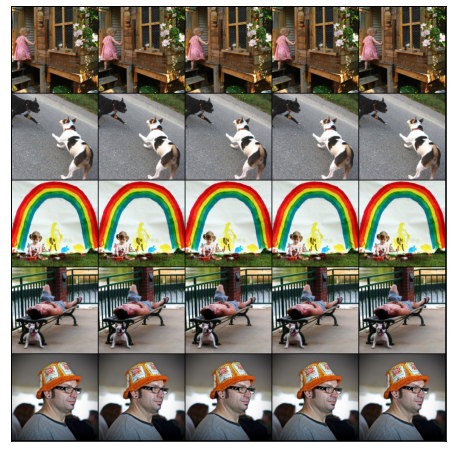

In [16]:
show_batch(loader)

# Model

In [17]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super().__init__()
        self.train_CNN = train_CNN
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.2)

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))

In [18]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim = 0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [19]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length = 20):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for i in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == '<EOS>':
                    break
        return [vocabulary.itos[idx] for idx in result_caption]

# Training

In [20]:
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
lr = 0.0003
epochs = 50

In [21]:
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [22]:
torch.cuda.empty_cache()

In [23]:
def train(epochs, lr, model, loader, opt_func = optim.Adam):
    optimizer = opt_func(model.parameters(), lr)
    criterion = nn.CrossEntropyLoss(ignore_index = dataset.vocab.stoi['<PAD>'])

    # Load the model
    model = model.to(device)

    # Only finetune the CNN
    for name, param in model.encoderCNN.resnet.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    model.train()

    for epoch in range(epochs):
        train_losses = []
        for imgs, captions in tqdm(loader):

            # Move data into the GPU
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            train_losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            del imgs
            del captions
            gc.collect()

            torch.cuda.empty_cache()
            
        train_losses = torch.Tensor(train_losses)
        avg_loss = torch.mean(train_losses)       
        print('Loss: ' + str(avg_loss))

In [ ]:
train(epochs, lr, model, loader)

  0%|          | 0/1265 [00:00<?, ?it/s]

Loss: tensor(4.2381)


  0%|          | 0/1265 [00:00<?, ?it/s]

Loss: tensor(3.2530)


  0%|          | 0/1265 [00:00<?, ?it/s]

Loss: tensor(3.0329)


  0%|          | 0/1265 [00:00<?, ?it/s]

Loss: tensor(2.8882)


  0%|          | 0/1265 [00:00<?, ?it/s]

Loss: tensor(2.7756)


  0%|          | 0/1265 [00:00<?, ?it/s]

# Results

In [ ]:
model.eval()

test_img1 = Image.open("../input/image-captioning-test/dog.jpg")
test_img1.show()
test_img1 = transform(test_img1.convert("RGB")).unsqueeze(0)
print("Example 1 CORRECT: Dog on a beach by the ocean")
print("Example 1 OUTPUT: " + " ".join(model.caption_image(test_img1.to(device), dataset.vocab)))

In [ ]:
model.eval()

test_img2 = Image.open("../input/image-captioning-test/child.jpg")
test_img2.show()
test_img2 = transform(test_img2.convert("RGB")).unsqueeze(0)
print("Example 2 CORRECT: Child holding red frisbee outdoors")
print("Example 2 OUTPUT: " + " ".join(model.caption_image(test_img2.to(device), dataset.vocab)))

In [ ]:
model.eval()

test_img3 = Image.open("../input/image-captioning-test/bus.png")
test_img3.show()
test_img3 = transform(test_img3.convert("RGB")).unsqueeze(0)
print("Example 3 CORRECT: Bus driving by parked cars")
print("Example 3 OUTPUT: " + " ".join(model.caption_image(test_img3.to(device), dataset.vocab)))

In [ ]:
model.eval()

test_img4 = Image.open("../input/image-captioning-test/boat.png")
test_img4.show()
test_img4 = transform(test_img4.convert("RGB")).unsqueeze(0)
print("Example 4 CORRECT: A small boat in the ocean")
print("Example 4 OUTPUT: " + " ".join(model.caption_image(test_img4.to(device), dataset.vocab)))

In [ ]:
model.eval()

test_img5 = Image.open("../input/image-captioning-test/horse.png")
test_img5.show()
test_img5 = transform(test_img5.convert("RGB")).unsqueeze(0)
print("Example 5 CORRECT: A cowboy riding a horse in the desert")
print("Example 5 OUTPUT: " + " ".join(model.caption_image(test_img5.to(device), dataset.vocab)))

In [ ]:
model.eval()

test_img6 = Image.open("../input/image-captioning-test/cat.jpg")
test_img6.show()
test_img6 = transform(test_img6.convert("RGB")).unsqueeze(0)
print("Example 4 CORRECT: A cat playing in the bush")
print("Example 4 OUTPUT: " + " ".join(model.caption_image(test_img6.to(device), dataset.vocab)))

In [ ]:
model.eval()

test_img7 = Image.open("../input/image-captioning-test/boats.jpg")
test_img7.show()
test_img7 = transform(test_img7.convert("RGB")).unsqueeze(0)
print("Example 4 CORRECT: Boats sailing in the sea")
print("Example 4 OUTPUT: " + " ".join(model.caption_image(test_img7.to(device), dataset.vocab)))